# Makespan minimization with Constraint Programming (OR-Tools)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from src.Logger import Logger

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker

# Domain data
from src.domain.Query import RoutingQuery
from src.domain.Initializer import JobsInitializer
from src.domain.Collection import LiveJobCollection

# Solver
from src.solvers.CP_Solver import Solver

# Data store access
from config.project_config import get_data_path, get_solver_logs_path

pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 29)

In [2]:
# File paths
examples_path = get_data_path("examples")

logs_path = get_solver_logs_path("Makespan", as_string=True)
logger = Logger(log_file = f"{logs_path}/cp_logger.log")


### I. Load routing

In [3]:
routings = RoutingQuery.get_by_source_name(source_name="Fisher and Thompson 10x10")

# Example
for routing in routings[:1]:
    print(routing)
    for operation in routing.operations:
        print(f" {operation}")

Routing(id='01-00', source_id=1)
 RoutingOperation(routing_id='01-00', position_number=0, machine_name='M00', duration=29)
 RoutingOperation(routing_id='01-00', position_number=1, machine_name='M01', duration=78)
 RoutingOperation(routing_id='01-00', position_number=2, machine_name='M02', duration=9)
 RoutingOperation(routing_id='01-00', position_number=3, machine_name='M03', duration=36)
 RoutingOperation(routing_id='01-00', position_number=4, machine_name='M04', duration=49)
 RoutingOperation(routing_id='01-00', position_number=5, machine_name='M05', duration=11)
 RoutingOperation(routing_id='01-00', position_number=6, machine_name='M06', duration=62)
 RoutingOperation(routing_id='01-00', position_number=7, machine_name='M07', duration=56)
 RoutingOperation(routing_id='01-00', position_number=8, machine_name='M08', duration=44)
 RoutingOperation(routing_id='01-00', position_number=9, machine_name='M09', duration=21)


### II. Create jobs routings (without any change)

In [4]:
jobs = JobsInitializer.create_simple_jobs(routings = routings, shuffle=False)
for job in jobs[:2]:
    print(job)
    for operation in job.operations:
        print(f" {operation}")


Job(id='01-0000', routing_id='01-00', arrival=None, earliest_start=0, due_date=None, sum_duration=395, max_bottleneck_utilization=None)
 JobOperation(job_id='01-0000', position_number=0, machine_name='M00', duration=29)
 JobOperation(job_id='01-0000', position_number=1, machine_name='M01', duration=78)
 JobOperation(job_id='01-0000', position_number=2, machine_name='M02', duration=9)
 JobOperation(job_id='01-0000', position_number=3, machine_name='M03', duration=36)
 JobOperation(job_id='01-0000', position_number=4, machine_name='M04', duration=49)
 JobOperation(job_id='01-0000', position_number=5, machine_name='M05', duration=11)
 JobOperation(job_id='01-0000', position_number=6, machine_name='M06', duration=62)
 JobOperation(job_id='01-0000', position_number=7, machine_name='M07', duration=56)
 JobOperation(job_id='01-0000', position_number=8, machine_name='M08', duration=44)
 JobOperation(job_id='01-0000', position_number=9, machine_name='M09', duration=21)
Job(id='01-0001', routing

In [5]:
jobs_collection = LiveJobCollection(jobs)
print(f"Total number of operations: {jobs_collection.count_operations()}")

Total number of operations: 100


## Scheduling

In [6]:
solver = Solver(
    jobs_collection = jobs_collection,
    schedule_start= 0,
    logger = logger
)
solver.build_makespan_model()
solver.log_model_info()

2025-08-16 16:17:12 INFO: Model info ---------------
2025-08-16 16:17:12 INFO: Number of preparable operations: 100
2025-08-16 16:17:12 INFO: Number of previous operations  : 0
2025-08-16 16:17:12 INFO: Number of active operation     : 0
2025-08-16 16:17:12 INFO: Number of variables            : 201
2025-08-16 16:17:12 INFO: Number of constraints          : 220


In [7]:
solver.solve_model(
    log_file= f"{logs_path}/cp_solver.log"
)
solver.log_solver_info()

2025-08-16 16:17:15 INFO: Solver info --------------
2025-08-16 16:17:15 INFO: Status              : OPTIMAL
2025-08-16 16:17:15 INFO: Objective value     : 930.0
2025-08-16 16:17:15 INFO: Best objective bound: 930.0
2025-08-16 16:17:15 INFO: Number of branches  : 14
2025-08-16 16:17:15 INFO: Wall time           : 3.51
2025-08-16 16:17:15 INFO: Tardiness cost      : 0
2025-08-16 16:17:15 INFO: Earliness cost      : 0
2025-08-16 16:17:15 INFO: Deviation cost      : 0


In [8]:
schedule_job_collection = solver.get_schedule()
df_schedule = schedule_job_collection.to_operations_dataframe()
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-0000,01-00,0,M00,76,29,105,None,0,None
1,01-0000,01-00,1,M01,446,78,524,None,0,None
2,01-0000,01-00,2,M02,524,9,533,None,0,None
3,01-0000,01-00,3,M03,547,36,583,None,0,None
4,01-0000,01-00,4,M04,583,49,632,None,0,None
5,01-0000,01-00,5,M05,643,11,654,None,0,None
6,01-0000,01-00,6,M06,654,62,716,None,0,None
7,01-0000,01-00,7,M07,721,56,777,None,0,None
...,...,...,...,...,...,...,...,...,...,...
92,01-0009,01-09,2,M02,363,61,424,None,0,None


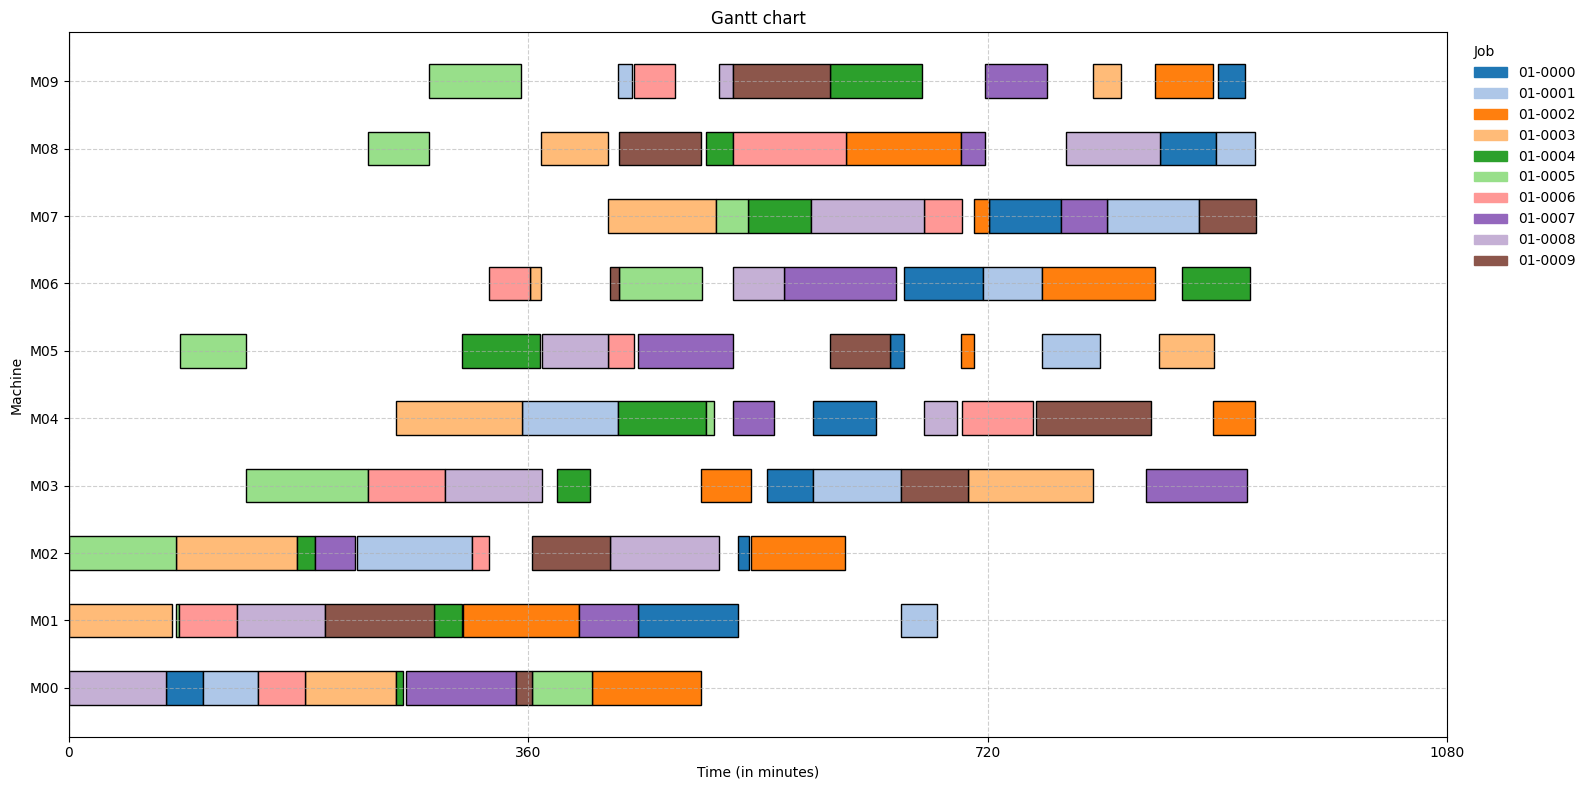

In [9]:
file_path = examples_path / "cp_makespan_gantt_chart.png"

fig = DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
fig.savefig(file_path, dpi=300)
plt.show()

In [10]:
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True